# fxローソク足チャートとMACDをプロット

* csvファイルからfxヒストリカルデータを読み出し
* `matplotlib.finance` を利用してローソク足チャートをプロット
* MACDを計算してプロット

In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mf
from matplotlib.dates import date2num
from mplfinance.original_flavor import candlestick_ochl

## 1時間足ヒストリカルデータをCSVファイルから読み取り

In [39]:
csv=pd.read_csv('USDJPY60.csv',
                 sep=',',
                 names=('YY.MM.DD', 'HH:MM', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'),
                 index_col=['YY.MM.DD', 'HH:MM'])

## ヒストリカルデータを日付でフィルタリング

In [40]:
data=csv # すべてのデータ
#data=csv['2017.02.01':'2017.02.09'] # 2017/2/1から2/9までのデータ
#data=csv['2016.09.01':'2016.10.31']
#data

In [41]:
# dates=[pd.to_datetime(i[0] + ' ' + i[1]) for i in data.index]

## データ整形
* dates[], op[], cl[], hi[], lo[]
    * 日付リスト, 始値リスト, 終値リスト, 最高値リスト, 最低値リスト
* candle[]
    * ローソク足チャートプロット用データ (日付, 始値, 終値, 最高値, 最低値)

In [42]:
dates = []
candle = []
for i, v in data.iterrows():
    t = pd.to_datetime(i[0] + ' ' + i[1]);
    dates.append(t)
    candle.append((date2num(t), v['OPEN'], v['CLOSE'], v['HIGH'], v['LOW']))

In [43]:
op=data['CLOSE'].tolist()
cl=data['CLOSE'].tolist()
hi=data['HIGH'].tolist()
lo=data['LOW'].tolist()

## MACD

1時間足の終値 `cl[]` を使用してMACDを計算

In [44]:
def ema(l, t):
    result = []
    for p in l:
        i = len(result)
        if i < t: # t日目までは単純平均
            result += [float(sum(result) + p) / (i + 1)]
        else:
            last = result[-1]
            result += [last + 2. * (p - last) / (t + 1)]
    return result

In [45]:
prices = cl
ema12 = np.array(ema(prices, 12))
ema24 = np.array(ema(prices, 24))
macd = ema12 - ema24
signal = np.array(ema(macd, 9))

## ローソク足チャート, MACDをプロット

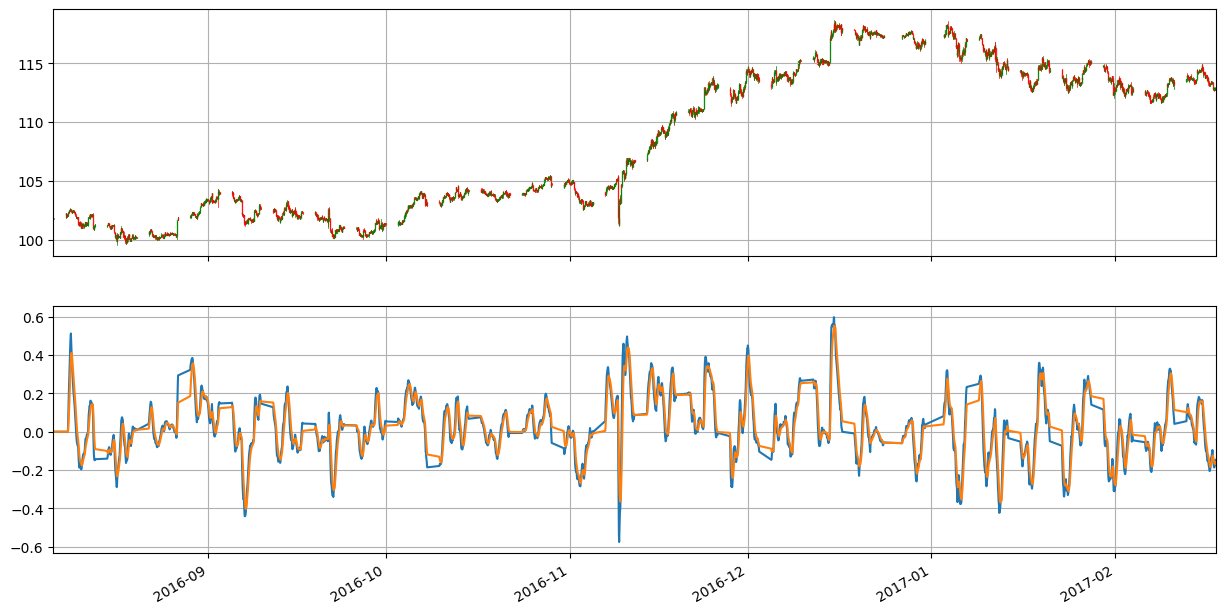

In [46]:
fig = plt.figure(figsize=(15, 8))

# candle chart
ax = fig.add_subplot(211)
ax.grid()
ax.set_xlim(dates[0], dates[-1])
candlestick_ochl(ax, candle, width=0.02, colorup='g', colordown='r', alpha=0.75)
fig.autofmt_xdate()

# MACD
ax = fig.add_subplot(212)
ax.grid()
ax.set_xlim(dates[0], dates[-1])
ax.plot(dates, macd)
ax.plot(dates, signal)
fig.autofmt_xdate()

## SignalとMACDの差分をプロット

`(signal-MACD)=0.0` ・・・ signalとMACDがクロスしたポイント

In [47]:
diff = signal - macd

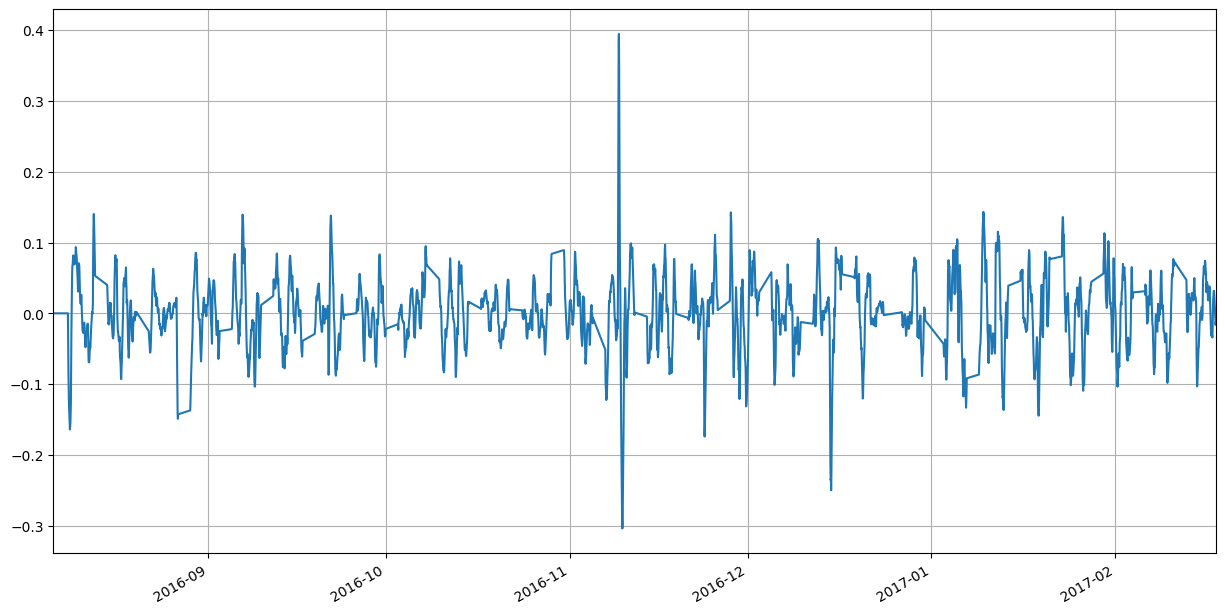

In [48]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(111)
ax.grid()
ax.set_xlim(dates[0], dates[-1])
ax.plot(dates, diff)
fig.autofmt_xdate()

# SignalとMACDのクロスを利用した売買シミュレーション

## 売買シミュレーション1

* SignalとMACDのクロスを、買いシグナル、売りシグナルとして用いる。

* シグナルでポジションを建てて、次のシグナルで決済した場合のプロフィットを計算する。

In [49]:
skip = True #diff[]の先頭の値0の要素をスキップ
position = 0
profit = []
for i in range(len(diff)):
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if flag==True and diff[i] < 0:
        #print "買いシグナル %s %f %f" % (dates[i], prices[i], position - prices[i])
        if position != 0:
            profit.append(position - prices[i])
        position = prices[i]
        flag = False
    elif flag==False and diff[i] > 0:
        #print "売りシグナル %s %f %f" % (dates[i], prices[i], prices[i] - position)
        if position != 0:
            profit.append(prices[i] - position)
        position = prices[i]
        flag = True

unit = 1
print("%d trades" % len(profit))
print("profit total %f average %f min %f max %f" % (sum(profit)*unit, sum(profit)*unit/len(profit), min(profit)*unit, max(profit)*unit))

243 trades
profit total 14.169000 average 0.058309 min -1.264000 max 2.559000


* 1回のトレードで1通貨(1ドル)の取引とする。
* 1トレードあたり平均0.058309円の利益が出た。
* 最も良いときで2.559円の利益が出た。
* 最も悪いときで-1.264円の損失が出た。
* トータルでは14.169円の利益が出た。

## 売買シミュレーション (2)

* SignalとMACDのクロスを、買いシグナル、売りシグナルとして用いる。

* シグナルでポジションを建て、次のシグナルまでの間に最も利益を出す（最も損失を少なくする）ポイントで決済できたと仮定した場合のプロフィットを計算する。

In [50]:
skip = True
position = []
profit = []
for i in range(len(diff)):
    #print "%s open %f close %f high %f low %f" % (dates[i], op[i], cl[i], hi[i], lo[i])
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if len(position)==2:
        #現ポジションを評価
        v=0
        if flag==True:
            #売りポジション
            v=position[0]-lo[i]
        else:
            #買いポジション
            v=hi[i]-position[0]
        if position[1] < v:
            if v>0:
                #print "profit gain %f" % v
                pass
            else:
                #print "profit loss %f" % v
                pass
            position[1] = v
    if flag==True and diff[i] < 0:
        #現ポジション結果保存
        if len(position)==2:
            profit.append(position[1])
        #新規ポジション
        #print "買い"
        position = [prices[i], -99999] #[買ポジション価格, 最大益]
        flag = False
    elif flag==False and diff[i] > 0:
        #前ポジション結果保存
        if len(position)==2:
            profit.append(position[1])
        #新規ポジション
        #print "売り"
        position = [prices[i], -99999] #[売ポジション価格, 最大益]
        flag = True

unit = 1
print("%d trades" % len(profit))
print("profit total %f average %f min %f max %f" % (sum(profit)*unit, sum(profit)*unit/len(profit), min(profit)*unit, max(profit)*unit))

243 trades
profit total 130.250000 average 0.536008 min -0.093000 max 3.509000


* 1回のトレードで1通貨(1ドル)の取引とする。
* 1トレードあたり平均0.536008円の利益が出た。
* 最も良いときで3.509円の利益が出た。
* 最も悪いときで-0.093円の損失が出た。
* トータルでは130.25円の利益が出た。

10000通貨なら5360円の利益。

10000通貨で243回トレードすれば 1,302,480円の利益。

In [52]:
average = sum(profit)*unit/len(profit)
n = len(set(filter(lambda x: x > average, profit)))
print("average %f good trade %d profit %f" % (average, n, average*n))

average 0.536008 good trade 86 profit 46.096708


* 1トレードあたりの平均利益0.536008円を上回る利益を出せたトレードは、243トレード中、87トレードだった。
* 決済ルールを **0.536008円の利益が出たら決済** とすると、その87トレードだけで、46.632716円の利益を出せた。
* 残りの156トレードの決済ルールを **次のシグナルが来たら決済** とするとどうなるか。

In [53]:
skip = True
rule = 0.536008 # プロフィットがこれを超えたら決済せよ
position = []
profit = []
for i in range(len(diff)):
    #print "%s open %f close %f high %f low %f" % (dates[i], op[i], cl[i], hi[i], lo[i])
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if len(position)==2 and position[1]==False: #現ポジションが未決済か?
        #現ポジションを評価
        v=0
        if flag==True:
            #売りポジション
            v=position[0]-lo[i]
        else:
            #買いポジション
            v=hi[i]-position[0]
        if rule < v:
            #現ポジション結果保存
            profit.append(rule) # ruleの価格で決済
            position[1]=True # 決済済み
            #print "fixed profit %f" % profit[-1]
    if flag==True and diff[i] < 0:
        #新規ポジション
        if len(position)==2 and position[1]==False:
            profit.append(position[0]-prices[i])
            #print "fixed profit %f" % profit[-1]
        #print "買い"
        position = [prices[i], False] #[買ポジション価格, 未決済]
        flag = False
    elif flag==False and diff[i] > 0:
        #前ポジション結果保存
        if len(position)==2 and position[1]==False:
            profit.append(prices[i]-position[0])
            #print "fixed profit %f" % profit[-1]
        #新規ポジション
        #print "売り"
        position = [prices[i], False] #[売ポジション価格, 未決済]
        flag = True

unit = 1
print("%d trades" % len(profit))
print("profit total %f average %f min %f max %f" % (sum(profit)*unit, sum(profit)*unit/len(profit), min(profit)*unit, max(profit)*unit))

243 trades
profit total 7.837696 average 0.032254 min -1.264000 max 0.536008


* 1トレードあたり平均0.032254円の利益が出た。
* 最も良いときで0.536円の利益が出た。
* 最も悪いときで-1.264円の損失が出た。
* トータルでは7.837696円の利益が出た。

10000通貨なら322.254円の利益。

10000通貨で243回トレードすれば、78,376.96円の利益。ちょっと寂しい。

## 検討事項

* **0.536008円の利益が出ないトレード**の決済ルールを洗練させる必要あり。

* シグナル発生時の状態（出来高や前シグナルとの高低差）と利益の間に相関関係がないだろうか?

* リアルタイムのデータを取るにはどうすれば?

## 検討(1) 0.536008円の利益が出ないトレードの決済ルール

* 前回は、0.536008円の利益が出たら決済、出なかったら次のシグナルで決済、というルールにした。

* ある程度で損切りするルールを追加しないと、損失が大きくなってしまう。

* そこで過去のトレードから利幅の平均を求め、その利幅のボトムを下回ったら損切りするルールを考えてみる。

* 例えば、SignalとMACDのクロスでx円の買いポジションを建て、そこから次のクロスまでの間の値動きの中で、最も値が上ったときでx+0.5円、最も値が下がったときでx-0.1円とすると、利幅は-0.1〜0.5である。

* この利幅の下限の平均値を下回ったら損切りするルールとする。

## 売買シミュレーション (3)

* SignalとMACDのクロスを、買いシグナル、売りシグナルとして用いる。

* シグナルでポジションを建て、次のシグナルまでの期間での利幅 `lower ~ upper` を得る。

* 複数のポジションでの `upper, lower` の平均値 `Eu, El` を求める。

* 評価益が `upper` を上回るか、評価損が `lower` 下回るか、次のシグナルが発生したとき決済するルールとする。

* `upper` の利益を得られるトレードの発生確率 `Pu`、`lower` の損失が発生するトレードの発生確率 `Pl` を計算する。

* `upper` と `lower` の間でうろうろしたトレードの発生確率は `1-(Pu+Pl)` となる。

* うろうろしたトレードの損益はトータルで0だったと仮定する。

* トレード数を多くすれば、プロフィットの期待値は `Pu * Eu + Pl * El` と考えることができるのではないだろうか。

In [55]:
skip = True
position = []
upper = []
lower = []
for i in range(len(diff)):
    #print "%s open %f close %f high %f low %f" % (dates[i], op[i], cl[i], hi[i], lo[i])
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if len(position)==3:
        #現ポジションを評価
        u=0
        l=0
        if flag==True:
            #売りポジション
            u=position[0]-lo[i]
            l=position[0]-hi[i]
        else:
            #買いポジション
            u=hi[i]-position[0]
            l=lo[i]-position[0]
        if position[1] < u:
            position[1] = u
        if position[2] > l:
            position[2] = l
    if flag==True and diff[i] < 0:
        #現ポジション結果保存
        if len(position)==3:
            upper.append(position[1])
            lower.append(position[2])
        #新規ポジション
        #print "買い"
        position = [prices[i], -99999,99999] #[買ポジション価格, 最大益,最大損]
        flag = False
    elif flag==False and diff[i] > 0:
        #前ポジション結果保存
        if len(position)==3:
            upper.append(position[1])
            lower.append(position[2])
        #新規ポジション
        #print "売り"
        position = [prices[i], -99999,99999] #[売ポジション価格, 最大益,最大損]
        flag = True

unit = 1
print("%d trades" % len(upper))
average=sum(upper)/len(upper)
n=len(set(filter(lambda x: x > average, upper)))
p=1.0*n/len(upper)*100
profit=average*n
print("upper average %f good trade %d (%.1f%%)" % (average, n, p))
average=sum(lower)/len(lower)
n=len(set(filter(lambda x: x < average, lower)))
p=1.0*n/len(lower)*100
profit+=average*n
print("lower average %f bad trade %d (%.1f%%)" % (average, n, p))
print("expected profit %f" % profit)

243 trades
upper average 0.536008 good trade 86 (35.4%)
lower average -0.297926 bad trade 85 (35.0%)
expected profit 20.773004


* 例えば1トレードでの取引通貨単位を10000通貨とする。

* 35.8%の確率で1トレードあたり5360.08円の利益、38.3%の確率で1トレードあたり2979.26円の損失、残り25.9%のトレードは損益がほぼ0。

* 1トレードの期待値は、`5360.08*0.358-2979.26*0.383=777.852円`

* 243回トレードでの期待値は、`777.852*243=189,018.036円`

前回が1トレードあたり利益322.254円だったので倍に増えた。

## 売買シミュレーション (4)

* SignalとMACDのクロスを、買いシグナル、売りシグナルとして用いる。

* シグナルでポジションを建てる

* 直近30回のポジションでの平均利幅の上限を超える、下限を下回る、次のシグナル、いずれかで決済

* 1分足のヒストリカルデータでシミュレーション

In [56]:
csv1=pd.read_csv('USDJPY1.csv',
                 sep=',',
                 names=('YY.MM.DD', 'HH:MM', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME'),
                 index_col=['YY.MM.DD', 'HH:MM'])

In [57]:
data1=csv1
#data1['OPEN'] #OPENの列
#data1[('2017.01.31', '00:02'):('2017.01.31', '00:03')] #('2017.01.31', '00:02')から('2017.01.31', '00:03')の行
#data1.loc[('2017.01.31', '00:02')] #('2017.01.31', '00:02')の行
#data1.loc[('2017.01.31', '00:02'), 'OPEN'] #('2017.01.31', '00:02')の行のOPEN
#data1.iloc[-1, 1] #最終行の1列目の値
#data1.loc[data1.index[-1], 'CLOSE'] #最終行のCLOSE

In [58]:
def trade(a, b, c, d):
    try:
        data1.loc[a]
        data1.loc[b]
        d1=data1[a:b] # "今回の売買シグナル時刻a" から "次の売買シグナル時刻b" までの1分足ヒストリカルデータを抽出
    except:
        return None # 1分足ヒストリカルデータなし
    if sum(d)==0:
        return None # 利幅確定前
    #print d1
    for i in d1.index:
        # 規定の利益, 損失に達したら決済
        if d1.loc[i, 'LOW'] <= (c+d[1]):
            return (c+d[1]) 
        if d1.loc[i, 'HIGH'] >= (c+d[0]):
            return (c+d[0])
    return d1.loc[d1.index[-1], 'CLOSE'] # 規定の利益, 損失に達する前に次のシグナルで決済

def strdate(date):
    # str(date)のフォーマットは "2017-01-01 01:01:30"
    # これを ("2017.01.01", "01:01") に変換して返す
    ts = str(date).split(" ")
    return (ts[0].replace('-', '.'), re.search(r"^[0-9]{2}:[0-9]{2}" , ts[1]).group(0))

def newpos(a, b):
    return [a, strdate(b), -99999, 99999] #[ポジション価格,開始時刻,最大益,最大損]

def margin(upper, lower, z):
    ul = len(upper)
    if ul < 30:
        return (0, 0)
    t0 = upper[ul-30:-1]
    t1 = lower[ul-30:-1]
    if z:
        # 買いポジション決済用の利幅
        return (sum(t0)/len(t0), sum(t1)/len(t1)) # high, low
    else:
        # 売りポジション決済用の利幅
        return (-sum(t1)/len(t1), -sum(t0)/len(t0)) # -low, -high

#trade(("2017.01.31", "00:00"), ("2017.01.31", "00:02"), 113.75, (0.5, -0.1))

In [59]:
import re
skip=True
position=[]
profit=[]
upper = []
lower = []
for i in range(len(diff)):
    if skip==True and diff[i]==0:
        continue
    elif skip==True:
        flag = True if diff[0] > 0 else False
        skip = False
        continue
    if len(position)==4:
        #現ポジションを評価
        if flag==True:
            #売りポジション
            u=position[0]-lo[i]
            l=position[0]-hi[i]
        else:
            #買いポジション
            u=hi[i]-position[0]
            l=lo[i]-position[0]
        if position[2] < u:
            position[2] = u
        if position[3] > l:
            position[3] = l
    if flag==True and diff[i] < 0:
        if len(position)==4:
            #売りポジション決済
            p = trade(position[1], strdate(dates[i+1]), position[0], margin(upper, lower, False))
            if p is not None:
                print("売りポジション決済")
                #print position
                #print p
                print(position[0]-p)
                profit.append(position[0]-p)
            #利幅
            upper.append(position[2])
            lower.append(position[3])
        #新規ポジション
        position = newpos(prices[i], dates[i+1])
        #print "買い %s" % position
        flag = False
    elif flag==False and diff[i] > 0:
        if len(position)==4:
            #買いポジション決済
            p = trade(position[1], strdate(dates[i+1]), position[0], margin(upper, lower, True))
            if p is not None:
                print("買いポジション決済")
                #print position
                #print p
                print(p-position[0])
                profit.append(p-position[0])
            #利幅
            upper.append(position[2])
            lower.append(position[3])
        #新規ポジション
        position = newpos(prices[i], dates[i+1])
        #print "売り %s" % position
        flag = True

#print profit
print("profit total %f average %f" % (sum(profit), sum(profit)/len(profit)))

買いポジション決済
-0.3773793103448355
売りポジション決済
-0.3857241379310352
買いポジション決済
0.6241379310344826
売りポジション決済
0.6031379310344818
買いポジション決済
0.5874827586206948
売りポジション決済
0.07699999999999818
買いポジション決済
-0.3780000000000001
売りポジション決済
0.6133793103448255
買いポジション決済
0.5837241379310285
売りポジション決済
-0.2780000000000058
買いポジション決済
-0.2909999999999968
売りポジション決済
-0.1839999999999975
買いポジション決済
-0.07199999999998852
売りポジション決済
0.5100000000000051
買いポジション決済
0.5028965517241346
売りポジション決済
0.5217931034482746
買いポジション決済
-0.3250689655172465
売りポジション決済
-0.3349310344827643
買いポジション決済
-0.16100000000000136
売りポジション決済
0.5281724137931008
買いポジション決済
0.5223793103448315
売りポジション決済
-0.16100000000000136
買いポジション決済
-0.005000000000009663
売りポジション決済
-0.30144827586207157
買いポジション決済
-0.2900689655172357
売りポジション決済
0.5153103448275829
買いポジション決済
-0.3249310344827592
売りポジション決済
-0.001999999999995339
profit total 2.317862 average 0.082781
